In [ ]:
from pathlib import Path
import sys

print("CWD:", Path.cwd())

PROJECT_ROOT = Path.cwd().parent     
SRC_DIR = PROJECT_ROOT / "src"

print("PROJECT_ROOT:", PROJECT_ROOT)
print("SRC_DIR exists:", SRC_DIR.exists())

if str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))

print("dsvm in sys.path now:", any("src" in p and "dsvm-dtw" in p for p in sys.path))

CWD: c:\Users\siam2\Desktop\dsvm-dtw\experiments
PROJECT_ROOT: c:\Users\siam2\Desktop\dsvm-dtw
SRC_DIR exists: True
dsvm in sys.path now: True


In [ ]:
# Phase I: Bootstrap 기반 control limit 설계
# dsvm_phase1_control_limit.ipynb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dsvm.arl_mcc import estimate_arl_for_h_mcc

In [8]:
# 프로젝트 루트 및 결과 디렉토리 설정
THIS_NOTEBOOK = Path().resolve()
PROJECT_ROOT = THIS_NOTEBOOK.parent   # dsvm-dtw/
RESULTS_DIR = PROJECT_ROOT / "results"
TABLES_DIR = RESULTS_DIR / "tables"
CONTROL_DIR = RESULTS_DIR / "control_limits"

TABLES_DIR.mkdir(parents=True, exist_ok=True)
CONTROL_DIR.mkdir(parents=True, exist_ok=True)

print("PROJECT_ROOT:", PROJECT_ROOT)
print("RESULTS_DIR :", RESULTS_DIR)
print("TABLES_DIR  :", TABLES_DIR)
print("CONTROL_DIR :", CONTROL_DIR)

# 데이터셋 / 실험 설정
dataset = "ECG5000"
stream = "train_incontrol"
mode = "dtw"         
data_version = "original"
seed = 2025
m = 100               
target_arl0 = 20

# 병합이 완료된 bootstrap p_swk 파일 범위
rep_start = 0
rep_end = 1999   # 예: 0~199 → rep_0 ~ rep_199

PROJECT_ROOT: C:\Users\siam2\Desktop\dsvm-dtw
RESULTS_DIR : C:\Users\siam2\Desktop\dsvm-dtw\results
TABLES_DIR  : C:\Users\siam2\Desktop\dsvm-dtw\results\tables
CONTROL_DIR : C:\Users\siam2\Desktop\dsvm-dtw\results\control_limits


In [9]:
# Phase I 데이터프레임 불러오기
file_name = (
    f"{dataset}_{stream}_p_swk_matrix_{mode}_{data_version}"
    f"({rep_start}~{rep_end})_bootstrap_seed{seed}_m={m}.csv"
)
file_path = TABLES_DIR / file_name

print("읽을 파일명:", file_name)
print("전체 경로  :", file_path)

# 't'를 index로 복구
df_pswk = pd.read_csv(file_path, index_col=0)
print("df_pswk.shape:", df_pswk.shape)
df_pswk.head()

읽을 파일명: ECG5000_train_incontrol_p_swk_matrix_dtw_original(0~1999)_bootstrap_seed2025_m=100.csv
전체 경로  : C:\Users\siam2\Desktop\dsvm-dtw\results\tables\ECG5000_train_incontrol_p_swk_matrix_dtw_original(0~1999)_bootstrap_seed2025_m=100.csv
df_pswk.shape: (100, 2000)


,rep_0,rep_1,rep_2,rep_3,rep_4,rep_5,rep_6,rep_7,rep_8,rep_9,...,rep_1990,rep_1991,rep_1992,rep_1993,rep_1994,rep_1995,rep_1996,rep_1997,rep_1998,rep_1999
t,,,,,,,,,,,,,,,,,,,,,
0,0.315617,0.327739,0.319124,0.331116,0.343810,0.331488,0.321058,0.318207,0.335589,0.338214,...,0.320758,0.324529,0.339559,0.334243,0.323022,0.311229,0.336698,0.333292,0.343956,0.334056
1,0.345039,0.337634,0.323090,0.338887,0.342662,0.354194,0.344575,0.326020,0.317070,0.338647,...,0.332243,0.336242,0.339218,0.329376,0.329622,0.319492,0.324475,0.340171,0.356794,0.320720
2,0.322348,0.322331,0.322868,0.349951,0.333298,0.326230,0.325470,0.322363,0.303648,0.334184,...,0.341674,0.326687,0.324319,0.327514,0.323866,0.361871,0.335808,0.330148,0.356727,0.324061
3,0.326510,0.328007,0.310647,0.332914,0.314388,0.329035,0.367552,0.330365,0.337946,0.350452,...,0.333268,0.340307,0.338426,0.317069,0.323281,0.344167,0.324998,0.322392,0.343864,0.326356
4,0.323176,0.326224,0.318564,0.319961,0.343384,0.340166,0.348289,0.319333,0.331906,0.309947,...,0.331426,0.325276,0.332205,0.324663,0.301693,0.347107,0.334523,0.354279,0.334572,0.351295


In [10]:
p_swk_mat = df_pswk.values  # shape (m, outer_reps)

print("p_swk min :", p_swk_mat.min())
print("p_swk max :", p_swk_mat.max())

# 아주 넓은 구간에서 coarase grid
h_grid_coarse = np.linspace(p_swk_mat.min(), p_swk_mat.max(), 20)

rows = []
for h in h_grid_coarse:
    est = estimate_arl_for_h_mcc(h=h, p_swk_mat=p_swk_mat, m=m)
    rows.append({"h": h, "ARL0": est["arl"]})

df_scan = pd.DataFrame(rows)
df_scan


p_swk min : 0.2644818901282311
p_swk max : 0.4304933881443785


,h,ARL0
0,0.264482,1.000000
1,0.273219,1.000500
2,0.281957,1.000500
3,0.290694,1.004000
4,0.299432,1.016000
5,0.308169,1.057500
6,0.316907,1.222500
7,0.325644,1.830000
8,0.334381,4.410500
9,0.343119,16.030256


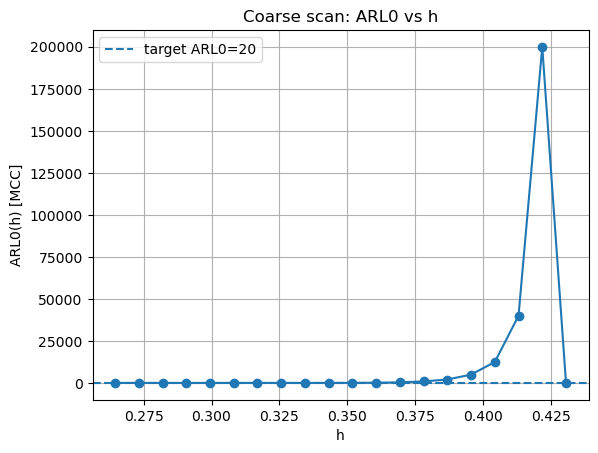

In [11]:
plt.plot(df_scan["h"], df_scan["ARL0"], marker="o")
plt.axhline(target_arl0, linestyle="--", label=f"target ARL0={target_arl0}")
plt.xlabel("h")
plt.ylabel("ARL0(h) [MCC]")
plt.title("Coarse scan: ARL0 vs h")
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# diff = ARL0 - target
df_scan["diff"] = df_scan["ARL0"] - target_arl0
df_scan

,h,ARL0,diff
0,0.264482,1.000000,-19.000000
1,0.273219,1.000500,-18.999500
2,0.281957,1.000500,-18.999500
3,0.290694,1.004000,-18.996000
4,0.299432,1.016000,-18.984000
5,0.308169,1.057500,-18.942500
6,0.316907,1.222500,-18.777500
7,0.325644,1.830000,-18.170000
8,0.334381,4.410500,-15.589500
9,0.343119,16.030256,-3.969744


In [13]:
brackets = []

for i in range(len(df_scan) - 1):
    h1, a1, d1 = df_scan.loc[i, ["h", "ARL0", "diff"]]
    h2, a2, d2 = df_scan.loc[i+1, ["h", "ARL0", "diff"]]

    # sign change 여부 확인
    if d1 == 0:
        brackets.append((h1, h1))
    elif d1 * d2 < 0:
        brackets.append((h1, h2))

brackets


[(0.3431189155043009, 0.3518563627683087)]

In [14]:
if len(brackets) == 0:
    print("경고: coarse grid에서 target ARL0를 가로지르는 구간을 찾지 못했습니다.")
    print("→ h 범위를 넓히거나, coarse grid 개수를 늘려서 다시 확인하는 게 좋습니다.")
    # 그래도 진행하고 싶다면, 그냥 전체 범위에서 best gap를 찾는 fallback을 만들 수도 있음
else:
    h_low, h_high = brackets[0]
    print(f"선택된 브래킷 구간: h_low = {h_low:.6f}, h_high = {h_high:.6f}")


선택된 브래킷 구간: h_low = 0.343119, h_high = 0.351856


In [15]:
target_arl = target_arl0
tolerance = 0.01
max_iter = 50  # coarse 브래킷 안이므로 너무 많이 안 돌려도 됨

lower = h_low
upper = h_high

best_h = None
best_arl = None
best_gap = float('inf')
best_sdrl = None
best_se = None

for _ in range(max_iter):
    mid = (lower + upper) / 2
    res = estimate_arl_for_h_mcc(mid, p_swk_mat, m)
    est_arl = res['arl']
    gap = abs(est_arl - target_arl)

    if gap < best_gap:
        best_gap = gap
        best_h = mid
        best_arl = est_arl
        best_sdrl = res['sdrl']
        best_se = res['se']

    if gap < tolerance:
        break

    # ARL가 target보다 작으면 → threshold가 너무 낮은 것 → 더 크게
    if est_arl < target_arl:
        lower = mid
    else:
        upper = mid

print(f"\n✅ 최적 h ≈ {best_h:.6f}")
print(f"   추정 ARL0(h*) ≈ {best_arl:.3f} (target={target_arl})")
print(f"   SDRL(h*)      ≈ {best_sdrl:.3f}")
print(f"   SE[ARL0(h*)]  ≈ {best_se:.4f}")
print(f"   최종 gap      ≈ {best_gap:.4f}")



✅ 최적 h ≈ 0.344695
   추정 ARL0(h*) ≈ 20.007 (target=20)
   SDRL(h*)      ≈ 30.255
   SE[ARL0(h*)]  ≈ 0.6765
   최종 gap      ≈ 0.0073


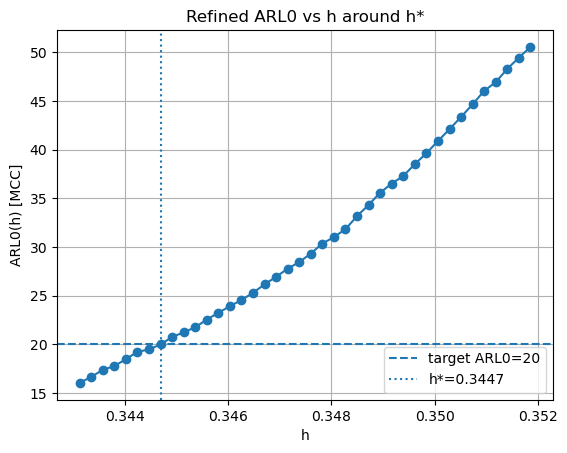

In [16]:
# 브래킷 주변을 조금 더 촘촘하게 보자
h_fine = np.linspace(h_low, h_high, 40)
rows_fine = []
for h in h_fine:
    est = estimate_arl_for_h_mcc(h, p_swk_mat, m)
    rows_fine.append({"h": h, "ARL0": est["arl"]})

df_fine = pd.DataFrame(rows_fine)

plt.plot(df_fine["h"], df_fine["ARL0"], marker="o")
plt.axhline(target_arl0, linestyle="--", label=f"target ARL0={target_arl0}")
plt.axvline(best_h, linestyle=":", label=f"h*={best_h:.4f}")
plt.xlabel("h")
plt.ylabel("ARL0(h) [MCC]")
plt.title("Refined ARL0 vs h around h*")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import json

# h*만 npy로 저장
# h_star = float(best_h)
# h_star_path = CONTROL_DIR / f"{dataset}_{stream}_h_star_{mode}_{data_version}_bootstrap_seed{seed}_m={m}.npy"
# np.save(h_star_path, np.array([h_star], dtype=float))
# print("h* 저장 경로 (npy):", h_star_path)

# 메타정보 json 저장
meta = {
    "dataset": dataset,
    "stream": stream,
    "mode": mode,
    "data_version": data_version,
    "seed": seed,
    "m": m,
    "target_ARL0": target_arl0,
    "h_star": float(best_h),
    "ARL0_h_star": float(best_arl),
    "SDRL_h_star": float(best_sdrl),
    "SE_ARL0_h_star": float(best_se),
    "rep_start": int(rep_start),
    "rep_end": int(rep_end),
}

h_star_json_path = CONTROL_DIR / f"{dataset}_{stream}_h_star_{mode}_{data_version}_bootstrap_seed{seed}_m={m}.json"
with open(h_star_json_path, "w", encoding="utf-8") as f:
    json.dump(meta, f, indent=2, ensure_ascii=False)

print("h* 메타정보 json 저장 경로:", h_star_json_path)


h* 저장 경로 (npy): C:\Users\siam2\Desktop\dsvm-dtw\results\control_limits\ECG5000_train_incontrol_h_star_dtw_original_bootstrap_seed2025_m=100.npy
h* 메타정보 json 저장 경로: C:\Users\siam2\Desktop\dsvm-dtw\results\control_limits\ECG5000_train_incontrol_h_star_dtw_original_bootstrap_seed2025_m=100.json


In [18]:
# 추후 Phase II에서 사용할 때는 
# h_star = float(np.load(h_star_path))